# Table of Contents

1. [Header](#header)
2. [Particles](#particles)
3. [FFT Data](#fft)
4. [Halo and Subhalo](#halo)<br>
    4.1. [FOF Data](#fof)<br>
    4.2. [SUBFIND Catalog](#subcat)

### This notebook gives examples of how to read in Indra data on the SciServer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import indratools as indra

Initialize the `runid` that specifies the Indra run and the snapshot of the particle data (`snapnum`) and FFT data (`tnum`) for redshift 0. `runid` can either be an integer from 128 to 511 or a tuple of (`X`,`Y`,`Z`) integers (each from 0 to 7), corresponding to the raveled and unraveled indices of an 8x8x8 cube. Currently, volumes 2_0_0 to 6_7_7 are available.

In [2]:
runid = (2, 0, 0); snapnum = 63; tnum = 504

You can convert between raveled and unraveled Indra run IDs using the `Run` class...

In [3]:
run = indra.Run(runid)
print(run.num,run.X,run.Y,run.Z)

128 2 0 0


... or by using utility functions:

In [4]:
print(indra.get_xyz(run.num))
print(indra.get_run_num(run.X,run.Y,run.Z))

(2, 0, 0)
128


The directory location `datadir` of run X_Y_Z is determined by `get_loc`. The default is to read from the FileDB mount if it is there and the DataScope mount if not. If `datascope = True` this sets `datadir` to the datascope directory location. When `datadir` is specified in the reading functions, it determines which simulation is read, and `runid` is ignored.

In [6]:
indra.get_loc(runid,snapnum)

'/home/idies/workspace/indra_filedb/data02_03/2_0_0/'

In [7]:
indra.get_loc((3,4,5),26)

'//home/idies/workspace/indra_dss//indra3/3_4_5/'

# Header
<a id="header"></a>

Length data are in units of Mpc/h, velocities in km/s, and masses in MSun/h. Set `verbose = True` to print the `datadir`.

In [8]:
header = indra.getheader(runid,snapnum,verbose=True)
print(header.keys())

Reading from /home/idies/workspace/indra_filedb/data02_03/2_0_0/
dict_keys(['np_file', 'mass', 'time', 'redshift', 'flag_sfr', 'flag_feedback', 'npart', 'flag_cooling', 'num_files', 'BoxSize', 'omega0', 'omegaL', 'hubble', 'flag_stellarage', 'flag_metals', 'hashtabsize'])


In [9]:
print(header['num_files'],header['npart'],header['mass'],header['time'],header['BoxSize'])

256 1073741824 70308895111.08398 0.9999999999999998 1000.0


# Particles
<a id="particles"></a>

Read the 64 snapshot numbers, redshifts, and scalefactors (for particle and halo data).

In [10]:
snaps,redshifts,times = indra.part_snapinfo()

Or retrieve redshifts and scalefactors for a subset of snapnumbers.

In [11]:
thisz, thisa = indra.part_snapinfo([41,snapnum])
print(thisz,thisa)

[9.88708e-01 2.22045e-16] [0.502839 1.      ]


Read positions only, no sorting:

In [12]:
pos_ns = indra.getpos(runid,snapnum)
print(pos_ns[0])

[0.21537165 2.7080586  0.31402177]


Get velocities too, and sort particles and velocities by their IDs (we need this step to plot halos later):

In [13]:
pos,vel,ids = indra.getparticles(runid,snapnum,sort=True)

In [14]:
print(pos[0],vel[0],np.max(ids))

[990.69543 998.1114  999.1573 ] [-420.89322   -20.328901  -82.65336 ] 1073741823


We have pre-computed power spectra from Cloud-In-Cell density interpolations of the particle positions, for all 320 currently available simulations, at select snapshots (30, 32, 34, 37, 41, 48, 58, and 63). These use a grid length of 512 and are saved as numpy binary files which are read to a dictionary object. (The CIC window function is deconvolved, but no anti-aliasing is performed.)

Here we read the power spectra and plot their mean and variance at redshift 1.

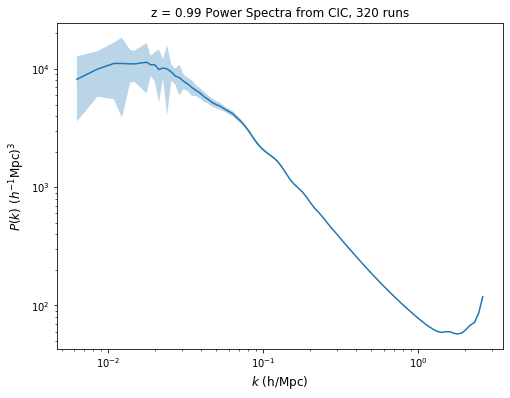

In [5]:
pk = indra.cic_pk(41)
thisz, _ = indra.part_snapinfo(41)
psmean = np.mean(pk['ps'],1)
psvar = np.std(pk['ps'],1)
plt.figure(figsize=(8,6))
plt.loglog(pk['k'],psmean)
plt.fill_between(pk['k'],psmean-psvar,psmean+psvar,alpha=.3)
plt.xlabel(r'$k$ (h/Mpc)',size='large')
plt.ylabel(r'$P(k)$ ($h^{-1}$Mpc)$^3$',size='large')
plt.title(f'z = {thisz:.2} Power Spectra from CIC, 320 runs',size='large');

# FFT Data
<a id="fft"></a>

Read the 505 snapshot numbers, redshifts, and scalefactors for FFT data (or a subset as with the particle snapshots).

In [15]:
fft_snaps,fft_redshifts,fft_times = indra.FFT_snapinfo()

Compute the k vectors. These arrays have the same shape as the FFT data.

In [16]:
kx,ky,kz = indra.getkvals()
k = np.sqrt(kx*kx+ky*ky+kz*kz)

Before reading, define some functions to calculate the power spectrum of this gridded FFT data.

In [17]:
def powspec(fft_re,fft_im,nbins=100, k=k):
    ps = fft_re*fft_re+fft_im*fft_im
    ps = ps[k>0] # remove k = 0
    k = k[k>0]
    
    # average PS in logarithmic bins of k
    ps1d, kbin = np.histogram(np.log10(k),nbins,weights=ps)
    counts = np.histogram(np.log10(k),nbins)[0]
    ps1d = ps1d[counts>0]/counts[counts>0] 
    
    binvals = kbin[0:nbins]+np.diff(kbin)//2
    binvals = binvals[counts>0]
    poisson = 1/np.sqrt(counts[counts>0])
    
    pk = {'k':10**binvals, 'ps': ps1d, 'poisson': poisson}
    return pk

In [18]:
# the cosmology is hard-coded here but om = header['omega0']
def growthfunc(a, om=0.272):
    ol = 1-om
#    a = 1./(1.+z)
    da=a/10000.
    integral = 0.
    for i in range(10000):
        aa=(i+1)*da
        integral+=da/((aa*np.sqrt(om/(aa**3)+ol))**3)

    return 5*om/2*np.sqrt(om/a**3+ol)*integral

Read the CAMB linear power spectrum, which is normalized to z=0. (So to compare to Plin, multiply PS(z) by D(z)^2/D(z=0)^2.)

In [19]:
kth,pth = indra.get_pklin()

Now plot the ratio of power spectra from the FFT data to the linear theory PS at different redshifts.

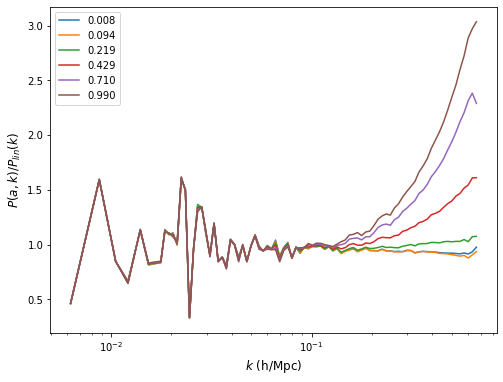

In [20]:
fft_re,fft_im,a = indra.getfft(runid,tnum)
pk = powspec(fft_re,fft_im) # need bins to interpolate linear PS
bins = pk['k']
plin = np.interp(bins,kth,pth)
norm = header['BoxSize']**3/header['npart']**2
plt.figure(figsize=(8,6))
for i in np.arange(0,501,100):
    fft_re,fft_im,a = indra.getfft(runid,i)
    pk = powspec(fft_re,fft_im)
    normL = growthfunc(a)**2/growthfunc(1)**2
    plt.plot(pk['k'],(pk['ps']*norm)/(plin*normL),label="{:.3f}".format(a)) 
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r'$k$ (h/Mpc)',size='large')
plt.ylabel(r'$P(a,k)/P_{lin}(k)$',size='large');

Now measure the mean and variance of P(k) at redshift 1, excluding the first 128 simulations (which might be re-run in the future; see the paper for explanation.)

In [21]:
tnum = (np.abs(fft_redshifts - 1.)).argmin() # snapshot closest to desired redshift
runstart = 128
runfinish = 448
numruns = runfinish-runstart
# first read one to get size of bins
fft_re,fft_im,a = indra.getfft(runid,tnum)
pk = powspec(fft_re,fft_im)
bins = pk['k']
psz1 = np.zeros([len(bins),numruns])
norm = header['BoxSize']**3/header['npart']**2
for i,s in enumerate(range(runstart,runfinish)):
    fft_re,fft_im,a = indra.getfft(s,tnum)
    pk = powspec(fft_re,fft_im)
    psz1[:,i] = pk['ps']*norm
psmean = np.mean(psz1,1)
psvar = np.std(psz1,1)

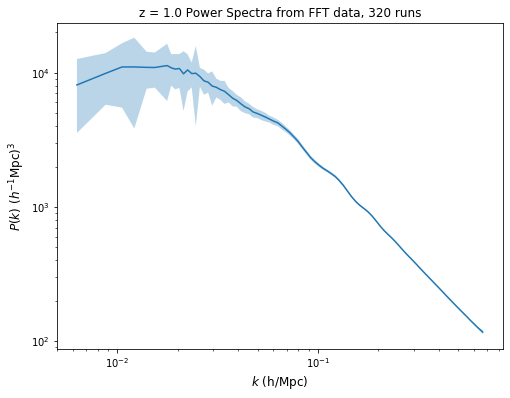

In [22]:
plt.figure(figsize=(8,6))
plt.loglog(bins,psmean)
plt.fill_between(bins,psmean-psvar,psmean+psvar,alpha=.3)
plt.xlabel(r'$k$ (h/Mpc)',size='large')
plt.ylabel(r'$P(k)$ ($h^{-1}$Mpc)$^3$',size='large')
plt.title('z = {:.2} Power Spectra from FFT data, {} runs'.format(fft_redshifts[tnum],numruns),size='large');

# Halo and Subhalo
<a id="halo"></a>

The FOF (or 'group') and SUBFIND headers contain the total number of groups/subhalos.

In [24]:
TotNgroups = indra.getsubheader(runid,snapnum,getfof=True)
print(TotNgroups)
TotNsubs = indra.getsubheader(runid,snapnum)
print(TotNsubs)

3037186
3107008


## FOF Data
<a id="fof"></a>

If all you want is the number of particles in each FOF halo (to multiply by `header['mass']`, for example), this is given by `groupLen`.

In [25]:
groupLen = indra.getfof(runid,snapnum)
print(np.min(groupLen),np.max(groupLen))

20 45443


`groupOffset` gives the information needed to index `groupids`, the particle IDs in each group.

In [26]:
groupLen,groupOffset,groupids = indra.getfofids(runid,snapnum)

The IDs of the particles in halo i are given by:

In [27]:
i = 0
haloIDs = groupids[groupOffset[i]:groupOffset[i]+groupLen[i]]

Let's plot some particles! I know that halo 0 (in snapshot 63 of 2_0_0) doesn't cross any boundaries, so we can ignore periodic boundary conditions for now. This will only work if you called `getparticles` with `sort=True`.

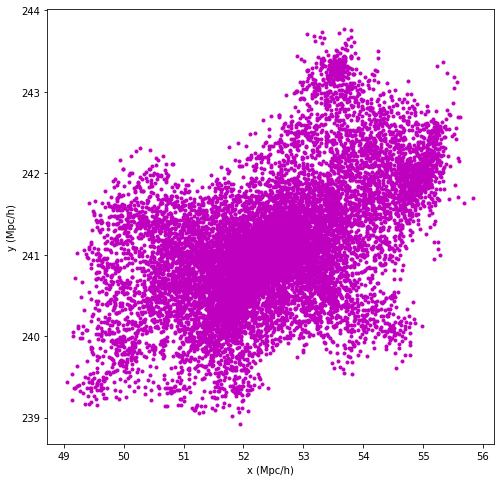

In [28]:
plt.figure(figsize=(8,8))
plt.plot(pos[haloIDs,0],pos[haloIDs,1],'m.')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)');

## Subhalo Catalog
<a id="subcat"></a>

There isn't much to the FOF data, since the unbinding procedure and calculation of halo properties is done by SUBFIND.

In [29]:
cat = indra.getsubcat(runid,snapnum)
subids = indra.getsubids(runid,snapnum)

Some properties are defined for every FOF group, and some for every subhalo.

In [30]:
for key in cat.keys():
    keytype = 'TotNFOF' if len(cat[key]) == TotNgroups else 'TotNSub'
    print('{} has length {} ({})'.format(key,keytype,len(cat[key])))

NsubPerHalo has length TotNFOF (3037186)
FirstSubOfHalo has length TotNFOF (3037186)
subLen has length TotNSub (3107008)
subOffset has length TotNSub (3107008)
subParentHalo has length TotNSub (3107008)
M200mean has length TotNFOF (3037186)
R200mean has length TotNFOF (3037186)
M200crit has length TotNFOF (3037186)
R200crit has length TotNFOF (3037186)
M200tophat has length TotNFOF (3037186)
R200tophat has length TotNFOF (3037186)
SubPos has length TotNSub (3107008)
SubVel has length TotNSub (3107008)
SubVelDisp has length TotNSub (3107008)
SubVmax has length TotNSub (3107008)
SubSpin has length TotNSub (3107008)
SubMostBoundID has length TotNSub (3107008)
SubHalfMass has length TotNSub (3107008)


In [31]:
print("mean M200 = {:.3e} Msun/h; mean R200 = {:.3} Mpc/h; mean velocity = {:.4} km/s".format(np.mean(cat['M200crit']),np.mean(cat['R200crit']),np.mean(np.abs(cat['SubVel']))))

mean M200 = 4.791e+12 Msun/h; mean R200 = 0.203 Mpc/h; mean velocity = 239.9 km/s


Indexing can get a bit tricky, so here are some examples. First let's pick the most massive FOF group with 5 subhalos.

In [32]:
has5 = np.where(cat['NsubPerHalo'] == 5)[0]
thishalo = np.argmax(cat['M200crit'][has5])
thishalo = has5[thishalo] # get the index of this halo in the full array
print('halo index = {}, M200 = {:.3e} Msun/h, R200 = {:.3} Mpc/h'.format(thishalo,cat['M200crit'][thishalo],cat['R200crit'][thishalo]))

halo index = 2373502, M200 = 8.893e+14 Msun/h, R200 = 1.56 Mpc/h


The IDs of the particles in this FOF halo (before unbinding) can be found via:

In [33]:
haloIDs = groupids[groupOffset[thishalo]:groupOffset[thishalo]+groupLen[thishalo]]

Let's get the indices of the subhalos with this parent halo. We can do this in two ways.

In [34]:
print(np.where(cat['subParentHalo'] == thishalo)[0])
subindices = cat['FirstSubOfHalo'][thishalo]+np.arange(cat['NsubPerHalo'][thishalo])
print(subindices)

[2428463 2428464 2428465 2428466 2428467]
[2428463 2428464 2428465 2428466 2428467]


The halo positions are calculated for every subhalo, so let's define the center as that of the main subhalo, and take care of periodic boundary conditions.

In [35]:
boxsize = header['BoxSize']
center = cat['SubPos'][cat['FirstSubOfHalo'][thishalo],:]
print(center)
halopos = pos[haloIDs,:] - center
halopos[halopos < boxsize/2.] += boxsize
halopos[halopos > boxsize/2.] -= boxsize
print(np.mean(halopos,axis=0))

[488.9635 874.7679 658.1727]
[-0.03627267 -0.09884765  0.05247776]


Now let's plot the particles in these halos! We'll plot the main halo in black first, so any particles that remain black were unbound by SUBFIND and don't belong to any subhalos (including the main `FirstSubOfHalo`).

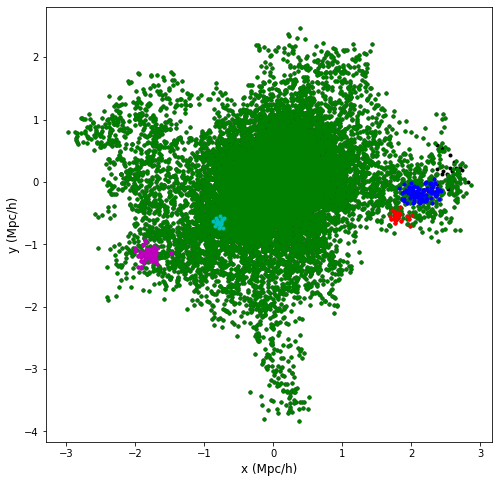

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(halopos[:,0],halopos[:,1],marker = '.',color='k')
colors = ['g','b','m','r','c']
for c, i in zip(colors,subindices):
    subIDs = subids[cat['subOffset'][i]:cat['subOffset'][i]+cat['subLen'][i]]
    subpos = pos[subIDs,:] - center
    subpos[subpos < boxsize/2.] += boxsize
    subpos[subpos > boxsize/2.] -= boxsize
    plt.scatter(subpos[:,0],subpos[:,1],marker ='.',color=c)
plt.xlabel('x (Mpc/h)',size='large')
plt.ylabel('y (Mpc/h)',size='large');

For an example of how to read the positions (and velocities) of all particles in a halo without needing to read the positions of the entire snapshot, see the `Shape3D_examples` notebook.